## TESTE DE HIPÓTESES

### MÓDULOS UTILIZADOS

In [744]:
import json, os, math, copy

import numpy as np
import sympy as sp
import scipy.stats as st

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as py

from fractions import Fraction

### CRIANDO MODELOS E PREPARANDO AS SIMULAÇÕES

#### CLASSE SIMULAÇÃO

In [745]:
class Sim(dict):
    def __init__(self, content = {}) -> None:
        # Carregando e salvando os dados da simulação como um dicionário
        super().__init__(Sim.__prepare_content(content))

    def pmf (self, x : int) -> float:
        return float(self['pmf'][x])

    def cdf (self, x : int) -> float:
        return float(self['cdf'][x])

    @staticmethod
    def __prepare_content(content):
        # Copia profunda dos dados (demora mais, mas é mais seguro)
        #sim = copy.deepcopy(content)
        sim = content

        sim['name'] = f"n = {sim['configs']['n']}, p0 = {sim['configs']['p0']}, s0 = {sim['configs']['s0']}"

        # Criando uma lista ordenada de cada simulação
        sim['sorted'] = list(sorted(sim['results']))
        
        # Calculando a pmf
        sim['freq'] = [0] * (sim['sorted'][-1] + 1)
        sim['pmf'] = [0.0] * (sim['sorted'][-1] + 1)
        p_per_elem = 1 / len(sim['sorted'])

        for x in sim['sorted']:
            sim['pmf'][x] += p_per_elem
            sim['freq'][x] += 1  # calculando frequências

        # Calculando a cdf
        sim['cdf'] = [0] * (sim['sorted'][-1] + 1)

        for i in range(1, len(sim['pmf'])):
            sim['cdf'][i] = sim['pmf'][i] + sim['cdf'][i - 1]

        # Normalizando os resultados com np e realizando cálculos útes
        sim['results_np'] = np.asarray(sim['sorted'])
        sim['mean'] = np.mean(sim['results_np'])
        sim['std'] = np.std(sim['results_np'], ddof=1)
        sim['normalized'] = (sim['results_np'] - sim['mean']) / sim['std']

        return sim

    # Agrupa frequências
    def group_freq(self, width : int = 5) -> list:
        return [sum(self['freq'][i : i + width]) for i in range(0, self['trial_count'], width)]

    # Distribui as frequências para atingir uma frequencia mínima não nula
    def distribute_freq(self, min_freq = 5):
        tc = self['trial_count'] # trial count
        fq = self['freq']
        table = []
        last_width = 0

        for width in range(1, tc):
            last_width = width
            table = self.group_freq(width)
            if min([x for x in table if x > 0]) >= min_freq:
                break
        
        self['freq_table'] = table
        return (last_width, table)


    # Retorna o valor crítico para o test ks.
    def ks_rc(self, ns : float):
        N = self['trial_count']
        
        suported_ns = [0.2, 0.1, 0.05, 0.01]
        base_value = [1.07, 1.22, 1.36, 1.63]

        try:
            base_value = base_value[suported_ns.index(ns)]
        except:
            raise Exception('Nível de significância não suportado, ecolha um entre: ' + str(suported_ns))

        if 35 >= N:
            raise Exception('O tamanho amotral da simulação é pequeno demais. Ele deve ser superior a 35.')
    
        return base_value / np.sqrt(N)


    @staticmethod
    def load_sims(dir_name, datasets_path='./datasets/'):
        target_dir = os.path.join(datasets_path, dir_name)
        sims = []
        for target in os.listdir(target_dir):
            target_path = os.path.join(target_dir, target)
            if not os.path.isfile(target_path):
                continue

            if target.endswith('.json'):
                with open(target_path, 'r') as fp:
                    sims.append(Sim(json.load(fp)))

        return sims

#### MODELO ANALÍTICO

Para seguir com a modelagem analítica, precisamos simplificar alguns aspectos do problema, para isso assumiremos:

1. $t_R \to \infty$
2. $\beta = 0$

A binomial negativa (desconsiderando as $s$ primeiras trials) (mesma do scipy):

$$
p_1(t; s, p) = \begin{pmatrix}t + s - 1 \\ s -1\end{pmatrix} p^{s} (1 - p)^{t}
$$

A binomial negativa (considerando as $s$ primeiras trials)

$$
p_2(t; s, p) = p_1(t-s; s, p) = \begin{pmatrix}t - 1 \\ s -1\end{pmatrix} p^{s} (1 - p)^{t - s}
$$

Importante notar que em cada ciclo do sistema, teríamos $n$ trials, então para obter a chance de falhar no $k$-ésimo ciclo, precisaríamos de:

$$
p_3(k; n, s, p) = \sum^{n}_{i = 1} p_2(n \cdot (k - 1) + i; s, p)
$$

Valor estimado:

$$
E = \frac{(s_0 + 1) (1 - p)}{p}
$$

CDF:

$$
I_{1-p}(s_0 + 1, k + 1)
$$


$I$ corresponde a função beta incompleta regularizada.

**Importante**

Para nosso problema, precisamos saber o número de trials antes da $s_0+1$ falha! 

In [746]:
# Analytical Version with Sympy and Scipy
k, t, i, n, s, p = sp.symbols("k t i n s p")

In [747]:
# Negative Binomial
neg_binomial_exp = sp.binomial(t - 1, s - 1) * (p ** s) * (1 - p) ** (t - s) 
neg_binomial_exp

p**s*(1 - p)**(-s + t)*binomial(t - 1, s - 1)

In [748]:
# Fix r to s definition
neg_binomial_exp = neg_binomial_exp.subs(s, s + 1) 
neg_binomial_exp

p**(s + 1)*(1 - p)**(-s + t - 1)*binomial(t - 1, s)

In [749]:
neg_binomial_pmf = sp.Sum(neg_binomial_exp.subs(t, n * (k - 1) + i), (i, 1, n)) # Group trials in same day
neg_binomial_pmf

Sum(p**(s + 1)*(1 - p)**(i + n*(k - 1) - s - 1)*binomial(i + n*(k - 1) - 1, s), (i, 1, n))

In [750]:
neg_binomial_cdf = sp.betainc_regularized(s + 1, k + 1, 0, p)
neg_binomial_cdf

betainc_regularized(s + 1, k + 1, 0, p)

In [751]:
esperaca = (s + 1) * (1 - p) / p
esperaca

(1 - p)*(s + 1)/p

#### CLASSE MODELO

In [752]:
class Model:

    def __init__(self, n : int, s0 : int, p0 : float) -> None:
        # Configurações
        self.n = int(n) # numero de máquinas
        self.s0 = int(s0) # número de máquinas reservas
        self.p0 = float(p0) # probabilidade de uma máquina quebrar em um turno
        self.configs = {
            'n': self.n,
            'p0': self.p0,
            's0': self.s0,
            'tr': 0,
            'beta': 0,
        }

        # Criando uma distribuição.
        self.dist = st.nbinom(self.s0 + 1, self.p0)
        self.E = self.ppf(0.5)
        self.not_p0 = 1 - self.p0

        # Lookup table, para atingir maior performance
        self.lookup = {
            'pmf': Fraction(str(self.p0 ** (self.s0 + 1) * self.not_p0 ** (-self.s0 - 1)))
        }

        # Expressões
        self.EXP = {
            'cdf': neg_binomial_cdf,
        }

        self.exp = {
            'cdf': self.EXP['cdf'].subs({'s': self.s0, 'p': self.p0}),
        }
        
        # Funções lambda úteis
        self.lambdas = {
            'cdf': sp.lambdify('k', self.exp['cdf']),
        }
        

    # pmf : probability mass function
    # To-do: fazer uma implementação melhor
    def pmf(self, x : int) -> float:
        x += 1 # tenho minhas dúvidas sobre essa linha

        # calculando os binomiais
        binomials = [sp.binomial(i + self.n * (x - 1) - 1, self.s0) for i in range(1, self.n + 1)]
        # calculando o segundo fator
        fator2 = [Fraction(str(self.not_p0 ** (i + self.n * (x - 1)))) for i in range(1, self.n + 1)]
        # calculando o denominador
        denominador = [self.lookup['pmf'].denominator * element.denominator for element in fator2]
        # calculando um resultado parcial parte 1
        parcial = [b / d for b, d in zip(binomials, denominador)]
        # calculando os subtotais
        subtotais = [self.lookup['pmf'].numerator * p * f.numerator for p, f in zip(parcial, fator2)]

        # retornando a soma e convertendo a fração para float
        return float(sum(subtotais))

    def ppf(self, x : float):
        return (self.dist.ppf(x) + self.s0) / self.n

    # cdf : cumulative distribution function
    def cdf(self, x : int) -> float:
        return self.lambdas['cdf'](x * self.n)

    # Realiza o teste ks
    def kstest(self, data):
        # Se data for uma lista de simulações, faça o teste ks para cada uma delas
        if isinstance(data, list):
            return [self.kstest(sim) for sim in data]

        # Se data for uma simulação apenas, 
        sim = data

        # variáveis relevantes
        distancia_max = [0, 0] 
        x_anterior = 0 

        # iterando por cada dado x
        for x in sim['sorted']:
            distancia = [0, 0] # distancia de cada iteração

            distancia[0] = abs(self.cdf(x) - sim['cdf'][x])
            distancia[1] = abs(self.cdf(x) - sim['cdf'][x_anterior])
            x_anterior = x

            distancia_max[0] = max(distancia_max[0], distancia[0])
            distancia_max[1] = max(distancia_max[1], distancia[1])

        return max(distancia_max)


### COMPARANDO OS MODELOS ÀS SIMULAÇÕES

Considere as seguintes configurações do sistema:

$$ 
    A: \quad n = 50 \quad p_0 = 0.006 \quad s_0 = 10
    \\
    B: \quad n = 100 \quad p_0 = 0.01 \quad s_0 = 25
$$

Podemos usar as classes "Model" e "Sim" para comparar o modelo analítico com os dados obtidos na simulação.


In [753]:
# Caregando as simulações
SIMS_A = Sim.load_sims('50-0_006-10')
SIMS_B = Sim.load_sims('100-0_01-25')

# Criando modelos
MODEL_A = Model(n = 50, p0 = 0.006, s0 = 10)
MODEL_B = Model(n = 100, p0 = 0.01, s0 = 25)

#### VIZUALIZANDO COMPARAÇÕES

##### COMPARANDO COM UMA NORMAL (QQ-PLOT)

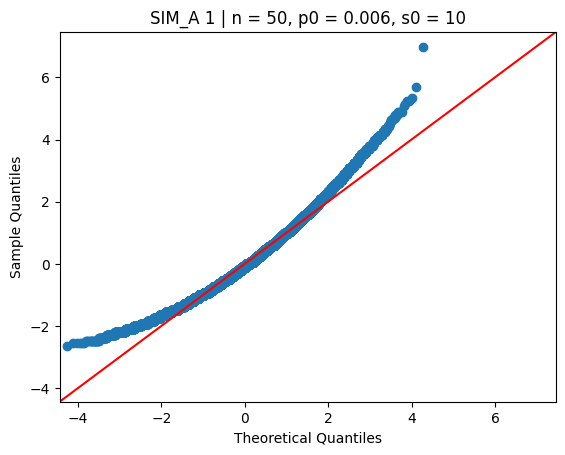

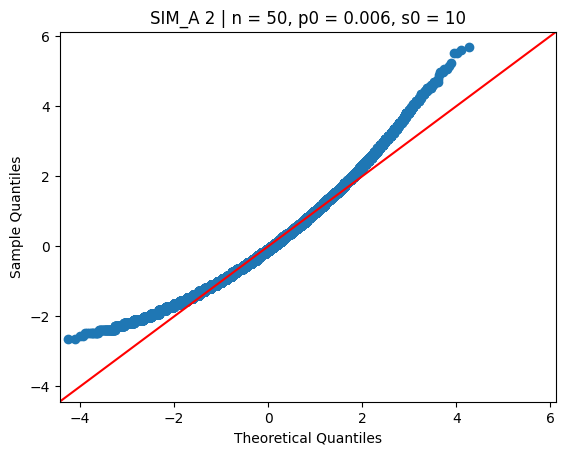

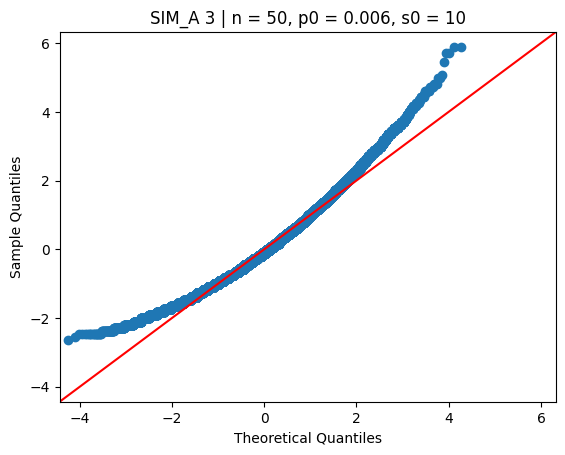

In [761]:
for i, sim in enumerate(SIMS_A, start=1):
    sm.qqplot(sim['normalized'], line ='45')
    plt.title(f'SIM_A {i} | {sim["name"]}')
py.show()

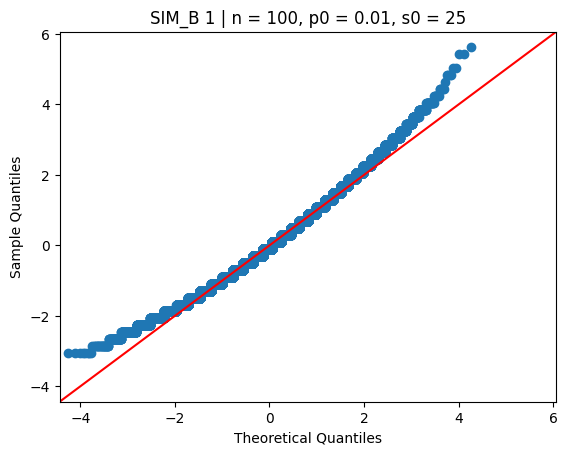

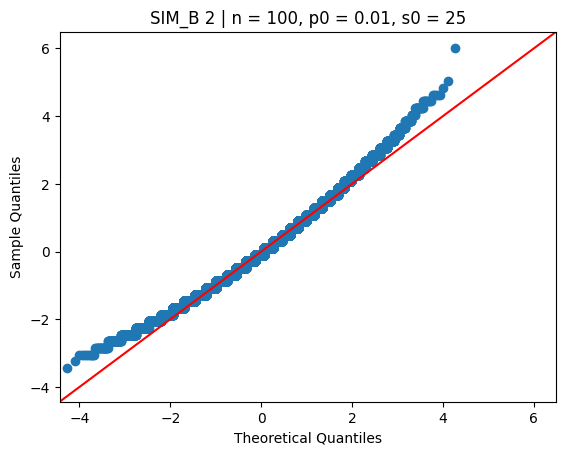

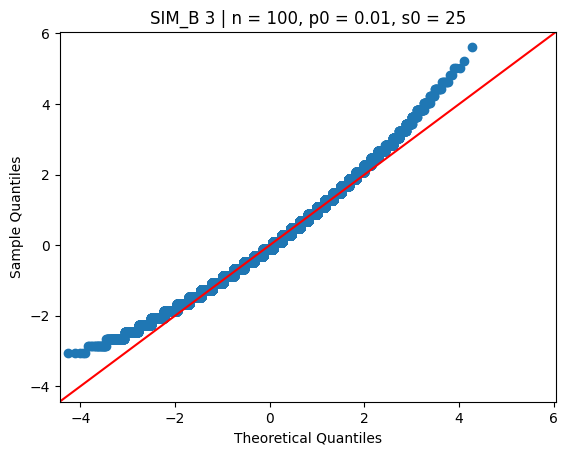

In [762]:
for i, sim in enumerate(SIMS_B, start=1):
    sm.qqplot(sim['normalized'], line ='45')
    plt.title(f'SIM_B {i} | {sim["name"]}')
py.show()

**Conclusão:**

---

Os dados não seguem uma distribuição normal.

##### COMPARANDO COM O MODELO (QQ-PLOT)

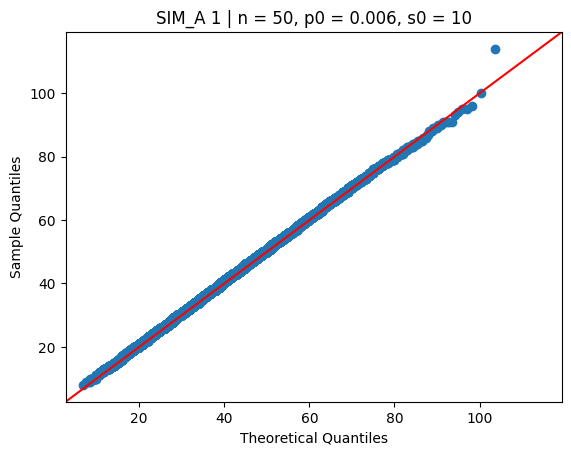

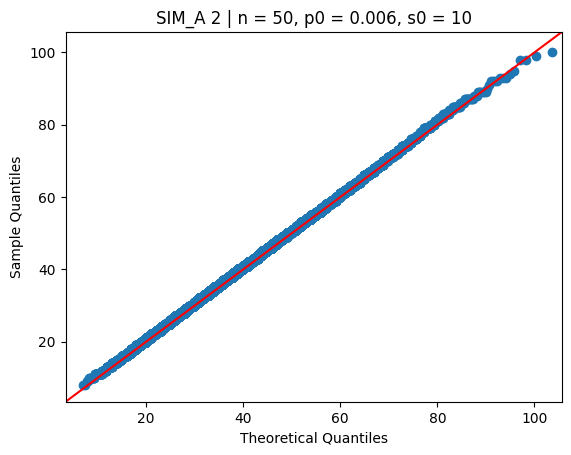

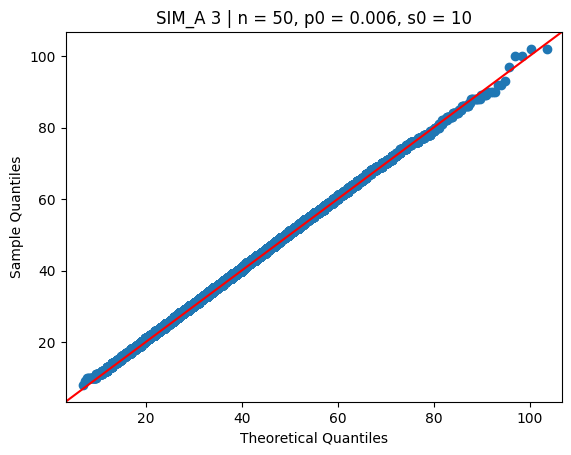

In [763]:
for i, sim in enumerate(SIMS_A, start=1):
    sm.qqplot(sim['results_np'], dist=MODEL_A, line ='45')
    plt.title(f'SIM_A {i} | {sim["name"]}')
py.show()

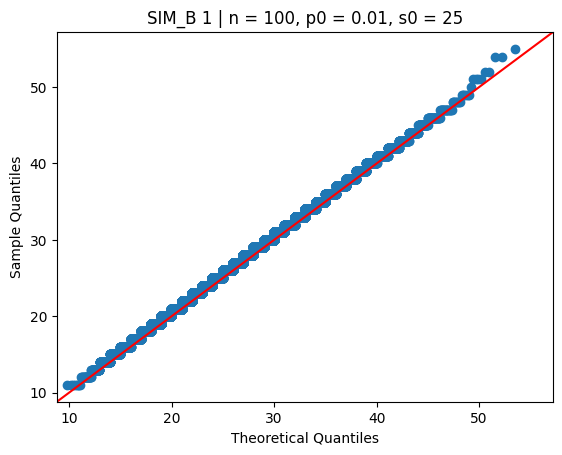

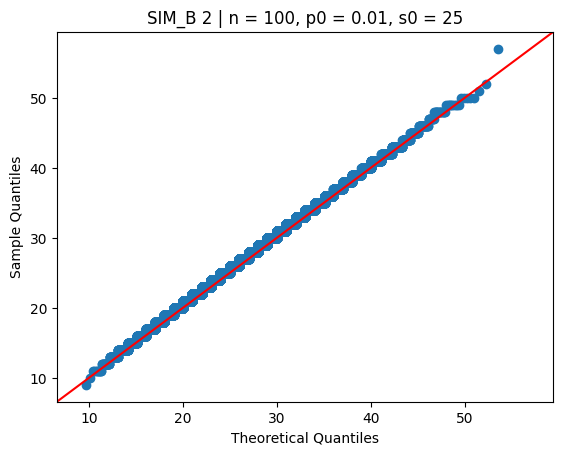

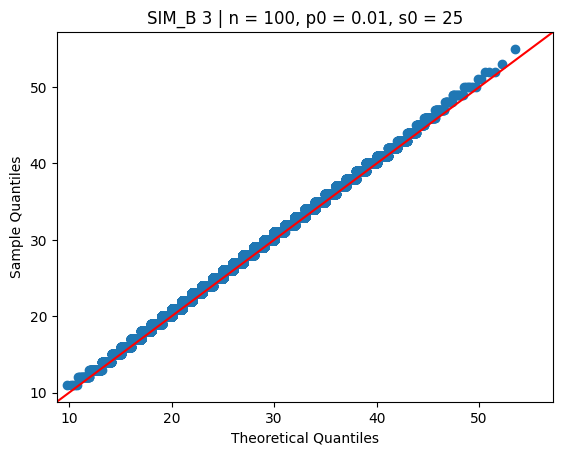

In [764]:
for i, sim in enumerate(SIMS_B, start=1):
    sm.qqplot(sim['results_np'], dist=MODEL_B, line ='45')
    plt.title(f'SIM_B {i} | {sim["name"]}')
py.show()

**Conclusão:**

---

Os dados seguem uma distribuição binomial negativa.

#### DISTRIBUIÇÃO DA MÉDIA AMOSTRAL

In [765]:
# MÉDIAS OBSERVADAS
A_xb = [sim['mean'] for sim in SIMS_A]
B_xb = [sim['mean'] for sim in SIMS_B]

print('MÉDIAS OBSERVADAS:')
print(f'A ({SIMS_A[0]["name"]}): ' + str(A_xb))
print(f'B ({SIMS_B[0]["name"]}): ' + str(B_xb))

MÉDIAS OBSERVADAS:
A (n = 50, p0 = 0.006, s0 = 10): [37.1967, 37.20629, 37.15617]
B (n = 100, p0 = 0.01, s0 = 25): [26.50959, 26.48403, 26.48708]


In [771]:
# Média teórica

#### TESTE KS

##### A NOSSA IMPLEMENTAÇÃO

In [766]:
# REGIÃO CRÍTICA
[(ns, SIMS_A[0].ks_rc(ns)) for ns in [0.2, 0.1, 0.05, 0.01]]

[(0.2, 0.0033836370963801657),
 (0.1, 0.0038579787454054225),
 (0.05, 0.0043006976178289955),
 (0.01, 0.005154512586074457)]

In [767]:
MODEL_A.kstest(SIMS_A)

[0.0476404008342175, 0.04810040083421735, 0.04563625744204153]

In [768]:
MODEL_B.kstest(SIMS_B)

[0.10245122665305345, 0.10181864005192842, 0.10060864005192921]

##### USANDO O SCIPY

In [769]:
[st.kstest(sim['results'], MODEL_A.cdf) for sim in SIMS_A]

[KstestResult(statistic=0.04764040083421206, pvalue=1.1284697961460565e-197),
 KstestResult(statistic=0.048100400834212076, pvalue=1.67158763355345e-201),
 KstestResult(statistic=0.045636257442037365, pvalue=2.0237253653835815e-181)]

In [770]:
[st.kstest(sim['results'], MODEL_B.cdf) for sim in SIMS_B]

[KstestResult(statistic=0.10245122665307721, pvalue=0.0),
 KstestResult(statistic=0.10181864005195063, pvalue=0.0),
 KstestResult(statistic=0.10060864005195064, pvalue=0.0)]